# CW06 - GUI paper exploration 6 - U-Net densities
Discard: Explorative work

In [434]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [524]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType

## Model

In [551]:
N = 20  # Number of data bins
SIGMA = 0.1  # Measurement uncertainty
NRES = 40

In [552]:
# Noise-free model
NPAR = 4

# Model and reference parameters
def spec(a, b, c, d, LW = 0.5):
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    x = spec(v[0], v[1], v[2], v[3])
    return dict(x=x)

# Noise model
def noise(sim, v, sigma = SIGMA):
    noise = np.random.randn(N)*sigma
    return dict(x = sim['x'] + noise)

# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 1.).ppf(u[0])
    b = scipy.stats.uniform(-1., 1.).ppf(u[1])
    c = scipy.stats.uniform(0., 10.).ppf(u[2])
    d = scipy.stats.uniform(0, 10.).ppf(u[3])
    return np.array([a, b, c, d])

### Zoom in

In [553]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,)))

In [554]:
prior = swyft.Prior(transform, NPAR)

In [570]:
NTRAIN = 10000

In [571]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 9939 new samples to simulator store.


In [572]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

In [573]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            LinearWithChannel(NRES, N, 128),
            nn.ReLU(),
            LinearWithChannel(NRES, 128, 128),
            nn.ReLU(),
            LinearWithChannel(NRES, 128, 2)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.repeat(1, NRES, 1)
        x = self.net(x)
        #x = x.reshape(-1, NRES, 2)
        return x

In [574]:
class MyTail(Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = MyNet()

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        t = torch.tensor(params[:,3]*NRES, dtype = torch.long)
        t = nn.functional.one_hot(t, num_classes = NRES) # nbatch, nmarg
        x = self.net(f) # nbatch, nmarg, 2
        nbatch = x.size(0)
        x = x.reshape(-1, 2)
        t = t.reshape(-1)
        x = x[torch.arange(len(t)), t].reshape(nbatch, -1) # nbatch, nmarg
        return x

In [575]:
post = swyft.Posteriors(dataset)
partition = range(1)
post.add(partition, device='cuda', head = DefaultHead, tail = MyTail)

In [576]:
post.train(partition, max_epochs = 20, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 10, 
           batch_size = 64, optimizer_args = dict(lr = 0.001))

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Training: lr=0.0005, Epoch=20, VL=53.88, TL=53.91


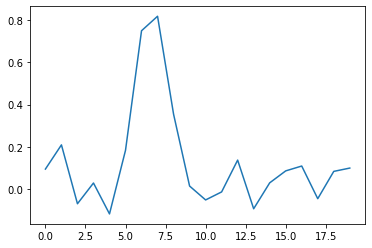

In [581]:
v0 = np.array([0.0, 0, 1.0, 3.5])
obs0 = noise(model(v0), v0)
plt.plot(obs0['x'])

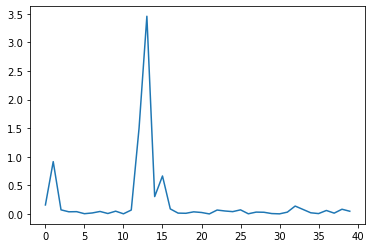

In [582]:
tail = post._ratios[((0,),)].tail.net
head = post._ratios[((0,),)].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))
tt = tail(f)[0,:,1].cpu().detach().numpy()
plt.plot(np.exp(tt))